In [1]:
from qtpg.team import Team
from qtpg.learner import Learner
from qtpg.program import Program
from qtpg.rule import Rule
from qtpg.figure13 import Figure13
from qtpg.figure13_hole_in_wall import Figure13HoleInWall
from qtpg.figure12 import Figure12
from qtpg.figure9 import Figure9
from qtpg.search_manager import SearchManager
import numpy as np
import uuid
import copy
import matplotlib.pyplot as plt

In [2]:
# env params
memorySize = 40
legalMove = 0.1
illegalMove = -0.01
outOfBounds = 0.0
memoryRepeat = -0.01
# memoryRepeat = 0.0
goalReached = 100

# envName = 'Figure 13'
# env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 13 Hole in Wall'
# env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 12'
# env = Figure12(5, 5, (4, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
envName = 'Figure 9'
env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

In [3]:
numGens = 200
maxTeamPool = 1
runs = 1
# init search manager and starting teams

# searchManager = SearchManager(maxTeamPool)

# # init teams
# adam_and_eve = []
# env.reset()
# init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
# init_team.init_search(env, [2, 3])
# adam_and_eve.append(init_team)
# win = False
# for adam in adam_and_eve:
# #     win = adam.search(env)
#     data = [adam, win]
#     searchManager.evaluate_team(data)

# variables for tracking fitness, for curves
scores = []
gens = []
maxes = []
averages = []
mins = []

run_winners = []
runs_score_track = []

for run in range(runs):
    maxes = []
    averages = []
    mins = []
    gens = []
    print(run)
    # init everything for new run
    searchManager = SearchManager(maxTeamPool)
    
    adam_and_eve = []
    env.reset()
    init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
    init_team.init_search(env, [2, 3])
    adam_and_eve.append(init_team)
    win = False
    for adam in adam_and_eve:
        data = [adam, win]
        searchManager.evaluate_team(data)
    
    
    for gen in range(numGens):
        print(f'GEN --> {gen}')
    #     if win:
    #         print(f'got to --> gen {gen+1}')
    #         break
        toEvaluateAfterGen = []
        scores = []
#         print(f'>>>>>>>>>>>>>>>>>>>>>>>Gen {gen+1} start!>>>>>>>>>>>>>>>>>>>>>>>')
        # get it started
        for parent in searchManager.teamPool:
            # only run if the team has not yet won
            if parent not in searchManager.winners:
#                 print(f'Parent: {parent.id}')
        #             print(f'Start: {parent.start_state}')
                env.current_state = parent.start_state

                # make offspring from parent, then let that offspring make a new rule
                child = copy.deepcopy(parent)
                child.id = uuid.uuid4()
                win = child.search_no_back_track(env)
#                 print(f'Child: {child.id}')
#                 print('Start Child Regions --------')
#                 for learner in child.learners:
#                     print(learner.program.rule.region)
#                 print('End Child Regions --------')
#                 print(f'Child Fitness: {child.fitness}') 
                toEvaluateAfterGen.append([child, win])
                scores.append(child)
            else:
#                 print(f'Skipping Team: {parent.id}')
#                 print(parent.fitness)
                scores.append(parent)

        for data in toEvaluateAfterGen:
            searchManager.evaluate_team(data)
#         print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
#         print(f'End of Gen {gen+1} Regions')
#         for i in range(len(searchManager.teamPool)):
#             print(f'Team: {i+1} --> {searchManager.teamPool[i].fitness}')
#             for learner in searchManager.teamPool[i].learners:
#                 print(learner.program.rule.region)
#         print(f'>>>>>>>>>>>>>>>>>>>>>>>Gen {gen+1} end!>>>>>>>>>>>>>>>>>>>>>>>')
        # start: manage fitness curves (at end of gen)
        gens.append(gen)
        total = 0
        max_fitness = -100
        min_fitness = 100

        for team in scores:
            total += team.fitness
            if team.fitness > max_fitness:
                max_fitness = team.fitness
            if team.fitness < min_fitness:
                min_fitness = team.fitness
        average_fitness = total / len(searchManager.teamPool)
        maxes.append(max_fitness)
        averages.append(average_fitness)
        mins.append(min_fitness)
    runs_score_track.append({'run': run, 'maxes': maxes, 'averages': averages, 'mins': mins})
        # end: manage fitness curves (at end of gen)
#     for team in searchManager.winners:
#         print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
#         print(team.fitness)
#         print('Learners:')
#         for learner in team.learners:
#             print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
#         print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')
    
    run_winners.append({'run': run, 'winners': searchManager.winners})

0
new step-------
2
(0, 3)
new step-------
2
(0, 4)
new step-------
2
(0, 4)
new step-------
3
(0, 3)
new step-------
3
(0, 2)
new step-------
3
(0, 1)
new step-------
3
(0, 0)
new step-------
3
(0, 0)
[0, 0, 0, 4]
GEN --> 0
clipping produced --> [0, 0, 1, 4]
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (1, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (2, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (3, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (4, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (5, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (6, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (7, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (8, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (9, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (9, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (8, 0)
New state for 103de68d-0c79-4aa0-92c4-c442ba3d71e8 --> (7,

clipping produced --> [0, 1, 1, 4]
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (2, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (3, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (4, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (5, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (6, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (7, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (8, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (9, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (9, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (8, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (7, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (6, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (5, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (4, 0)
New state for 796c144b-29b2-45e9-b98e-300ff92d6d5f --> (3, 0)
New state for 796c144b-29b2-45e9-b9

clipping produced --> [1, 6, 0, 0] and [1, 6, 2, 5]
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 7)
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 8)
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 9)
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 9)
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 8)
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 7)
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 6)
New state for 599bd745-0d12-45e7-b1d0-0404183fb4e0 --> (1, 6)
[0, 1, 6, 9]
GEN --> 85
clipping produced --> [0, 1, 6, 8]
New state for d49d62ee-2edf-4d99-aa0d-abb890f73e38 --> (0, 9)
New state for d49d62ee-2edf-4d99-aa0d-abb890f73e38 --> (0, 9)
New state for d49d62ee-2edf-4d99-aa0d-abb890f73e38 --> (1, 9)
New state for d49d62ee-2edf-4d99-aa0d-abb890f73e38 --> (2, 9)
New state for d49d62ee-2edf-4d99-aa0d-abb890f73e38 --> (3, 9)
New state for d49d62ee-2edf-4d99-aa0d-abb890f73e38 --> (4, 9)
[1, 9, 0, 4]
GEN --> 

In [4]:
#fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for average in averages:
#     y.append(average)
# plt.xlabel('Generation')
# plt.ylabel('Average Score')
# plt.plot(x, y)
# plt.show()

In [5]:
# #fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for max_ in maxes:
#     y.append(max_)
# plt.xlabel('Generation')
# plt.ylabel('Max Score')
# plt.plot(x, y)
# plt.show()

In [6]:
for team in searchManager.winners:
    print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
    print(team.fitness)
    print('Learners:')
    for learner in team.learners:
        print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
    print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')

$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$
162.07
Learners:
Region: [0, 0, 1, 4] --> Action: [2, 3]
Region: [1, 0, 0, 7] --> Action: [0, 1]
Region: [1, 0, 9, 9] --> Action: [0, 1]
Region: [0, 8, 0, 3] --> Action: [2, 3]
Region: [0, 8, 5, 5] --> Action: [2, 3]
Region: [1, 4, 5, 7] --> Action: [0, 1]
Region: [1, 4, 9, 9] --> Action: [0, 1]
Region: [0, 8, 1, 5] --> Action: [2, 3]
Region: [1, 0, 0, 8] --> Action: [0, 1]
Region: [0, 9, 0, 6] --> Action: [2, 3]
Region: [0, 9, 8, 9] --> Action: [2, 3]
Region: [1, 7, 0, 8] --> Action: [0, 1]
Region: [0, 9, 1, 9] --> Action: [2, 3]
Region: [1, 0, 0, 7] --> Action: [0, 1]
Region: [1, 0, 9, 9] --> Action: [0, 1]
Region: [0, 8, 1, 5] --> Action: [2, 3]
Region: [1, 0, 0, 1] --> Action: [0, 1]
Region: [1, 0, 3, 9] --> Action: [0, 1]
Region: [0, 2, 0, 3] --> Action: [2, 3]
Region: [1, 4, 0, 1] --> Action: [0, 1]
Region: [1, 4, 3, 3] --> Action: [0, 1]
Region: [0, 2, 0, 0] --> Action: [2, 3]
Region: [0, 2, 2, 4] --> Action: [2, 3]
Region: [1,

## Average Max Fitness Curves

In [7]:
print(runs_score_track[0]['maxes'][0])
print(len(runs_score_track))
print(len(runs_score_track[0]))
print(len(runs_score_track[0]['maxes']))

2.1800000000000006
1
4
200


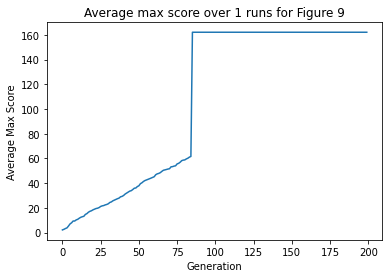

In [8]:
#fitness curves
x = []
y = []
average_maxes = np.zeros(numGens)
# average_maxes = np.zeros(100)

for i in range(len(gens)):
    for q in range(len(runs_score_track)):
        average_maxes[i] += runs_score_track[q]['maxes'][i]
    average_maxes[i] /= len(runs_score_track)
    
for gen in gens:
    x.append(gen)

plt.title(f'Average max score over {len(runs_score_track)} runs for {envName}')
plt.xlabel('Generation')
plt.ylabel('Average Max Score')
plt.plot(x, average_maxes)
plt.show()

## Reinforcement Learning + Victory Lap

In [9]:
print(run_winners)
for learner in team.learners:
    print(learner.program.rule.region)

[{'run': 0, 'winners': [<qtpg.team.Team object at 0x7fc4980d8d60>]}]
[0, 0, 1, 4]
[1, 0, 0, 7]
[1, 0, 9, 9]
[0, 8, 0, 3]
[0, 8, 5, 5]
[1, 4, 5, 7]
[1, 4, 9, 9]
[0, 8, 1, 5]
[1, 0, 0, 8]
[0, 9, 0, 6]
[0, 9, 8, 9]
[1, 7, 0, 8]
[0, 9, 1, 9]
[1, 0, 0, 7]
[1, 0, 9, 9]
[0, 8, 1, 5]
[1, 0, 0, 1]
[1, 0, 3, 9]
[0, 2, 0, 3]
[1, 4, 0, 1]
[1, 4, 3, 3]
[0, 2, 0, 0]
[0, 2, 2, 4]
[1, 1, 0, 2]
[1, 1, 4, 9]
[0, 3, 1, 4]
[1, 0, 0, 1]
[1, 0, 3, 9]
[0, 2, 0, 3]
[1, 4, 1, 3]
[0, 0, 0, 1]
[0, 0, 3, 4]
[1, 2, 1, 3]
[0, 0, 0, 1]
[0, 0, 3, 4]
[1, 2, 1, 3]
[0, 0, 0, 0]
[0, 0, 2, 4]
[1, 1, 0, 2]
[1, 1, 4, 9]
[0, 3, 0, 1]
[0, 3, 3, 4]
[1, 2, 0, 0]
[1, 2, 2, 3]
[0, 1, 0, 1]
[0, 1, 3, 4]
[1, 2, 0, 1]
[1, 2, 3, 3]
[0, 2, 0, 0]
[0, 2, 2, 4]
[1, 1, 0, 0]
[1, 1, 2, 9]
[0, 1, 0, 0]
[0, 1, 2, 4]
[1, 1, 0, 6]
[1, 1, 8, 9]
[0, 7, 0, 3]
[0, 7, 5, 5]
[1, 4, 5, 7]
[1, 4, 9, 9]
[0, 8, 0, 1]
[0, 8, 3, 5]
[1, 2, 5, 8]
[0, 9, 0, 1]
[0, 9, 3, 9]
[1, 2, 5, 5]
[1, 2, 7, 9]
[0, 6, 1, 5]
[1, 0, 0, 8]
[0, 9, 0, 1]
[0, 9, 3, 9]
[1, 2, 6

In [14]:
# team = searchManager.winners[0]
team = run_winners[0]['winners'][0]
team.discount = 0.9
team.alpha = 0.5
for learner in team.learners:
    print(learner.program.rule.region)

for i in range(5):
    print(f'Epoch: {i+1} --------')
    env.reset()
    print(f'curr -> {env.current_state}')
    win = False
    selected_learner = team.select_learner(env, [0, 0, 0, 0])
    while not win:
        win, needs_update, reward, winning_action = team.q_evaluation(env, selected_learner)
        print(reward)
        print('hi')
        if not win:
            selected_learner = team.select_learner(env, selected_learner.program.rule.region)
            team.transition_update(reward, winning_action, needs_update, selected_learner)

    team.final_update(reward, winning_action, needs_update)

print(win)
for learner in team.learners:
    print(f'{learner.program.rule.region}')
    for i in range(len(learner.program.rule.action_set)):
          print(f'{learner.program.rule.action_set[i]} --> {learner.program.rule.value_set[i]}')

[0, 0, 1, 4]
[1, 0, 0, 7]
[1, 0, 9, 9]
[0, 8, 0, 3]
[0, 8, 5, 5]
[1, 4, 5, 7]
[1, 4, 9, 9]
[0, 8, 1, 5]
[1, 0, 0, 8]
[0, 9, 0, 6]
[0, 9, 8, 9]
[1, 7, 0, 8]
[0, 9, 1, 9]
[1, 0, 0, 7]
[1, 0, 9, 9]
[0, 8, 1, 5]
[1, 0, 0, 1]
[1, 0, 3, 9]
[0, 2, 0, 3]
[1, 4, 0, 1]
[1, 4, 3, 3]
[0, 2, 0, 0]
[0, 2, 2, 4]
[1, 1, 0, 2]
[1, 1, 4, 9]
[0, 3, 1, 4]
[1, 0, 0, 1]
[1, 0, 3, 9]
[0, 2, 0, 3]
[1, 4, 1, 3]
[0, 0, 0, 1]
[0, 0, 3, 4]
[1, 2, 1, 3]
[0, 0, 0, 1]
[0, 0, 3, 4]
[1, 2, 1, 3]
[0, 0, 0, 0]
[0, 0, 2, 4]
[1, 1, 0, 2]
[1, 1, 4, 9]
[0, 3, 0, 1]
[0, 3, 3, 4]
[1, 2, 0, 0]
[1, 2, 2, 3]
[0, 1, 0, 1]
[0, 1, 3, 4]
[1, 2, 0, 1]
[1, 2, 3, 3]
[0, 2, 0, 0]
[0, 2, 2, 4]
[1, 1, 0, 0]
[1, 1, 2, 9]
[0, 1, 0, 0]
[0, 1, 2, 4]
[1, 1, 0, 6]
[1, 1, 8, 9]
[0, 7, 0, 3]
[0, 7, 5, 5]
[1, 4, 5, 7]
[1, 4, 9, 9]
[0, 8, 0, 1]
[0, 8, 3, 5]
[1, 2, 5, 8]
[0, 9, 0, 1]
[0, 9, 3, 9]
[1, 2, 5, 5]
[1, 2, 7, 9]
[0, 6, 1, 5]
[1, 0, 0, 8]
[0, 9, 0, 1]
[0, 9, 3, 9]
[1, 2, 6, 9]
[0, 5, 0, 4]
[0, 5, 6, 7]
[1, 5, 5, 6]
[1, 5, 8, 9]
[0, 7, 0, 0]

[2, 3]
[0.44327718779857167, 0]
2
(5, 4)
[0, 5, 0, 4]
[2, 3]
[0.44327718779857167, 0]
2
(5, 5)
Winning action: 2
0.1
hi
regions --> [0, 5, 0, 4] is eligible with [1, 5, 5, 6]
regions --> [0, 5, 0, 4] is eligible with [0, 5, 0, 5]
[1, 5, 5, 6] --> [0, 1]
[0, 5, 0, 5] --> [2, 3]
[1, 5, 5, 6]
[0, 1]
[0.49992368442041346, 0]
0
(6, 5)
[1, 5, 5, 6]
[0, 1]
[0.49992368442041346, 0]
0
(7, 5)
Winning action: 0
0.1
hi
regions --> [1, 5, 5, 6] is eligible with [0, 7, 5, 5]
regions --> [1, 5, 5, 6] is eligible with [0, 7, 2, 5]
[0, 7, 5, 5] --> [2, 3]
[0, 7, 2, 5] --> [2, 3]
[0, 7, 2, 5]
[2, 3]
[0, 0.5306170039578795]
3
(7, 4)
[0, 7, 2, 5]
[2, 3]
[0, 0.5306170039578795]
3
(7, 3)
[0, 7, 2, 5]
[2, 3]
[0, 0.5306170039578795]
3
(7, 2)
[0, 7, 2, 5]
[2, 3]
[0, 0.5306170039578795]
3
(7, 1)
Winning action: 3
0.1
hi
regions --> [0, 7, 2, 5] is eligible with [1, 1, 4, 9]
regions --> [0, 7, 2, 5] is eligible with [1, 1, 4, 9]
regions --> [0, 7, 2, 5] is eligible with [1, 1, 2, 9]
regions --> [0, 7, 2, 5] is e

[1, 0, 3, 9]
[0, 1]
[0, 0.5811193208847838]
1
(4, 0)
[1, 0, 3, 9]
[0, 1]
[0, 0.5811193208847838]
1
(3, 0)
[1, 0, 3, 9]
[0, 1]
[0, 0.5811193208847838]
1
(2, 0)
Winning action: 1
0.1
hi
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 3]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 0]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 3]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 0]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 2]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 1]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 2]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 8]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[0, 2, 0, 3] --> [2, 3]
[0, 2, 0, 0] --> [2, 3]
[0, 2, 0, 3] --> [2, 3]
[0, 2, 0, 0]

regions --> [0, 2, 0, 3] is eligible with [1, 4, 1, 3]
regions --> [0, 2, 0, 3] is eligible with [0, 2, 2, 4]
regions --> [0, 2, 0, 3] is eligible with [0, 2, 3, 4]
regions --> [0, 2, 0, 3] is eligible with [0, 2, 4, 4]
regions --> [0, 2, 0, 3] is eligible with [0, 2, 1, 4]
[0, 2, 2, 4] --> [2, 3]
[1, 4, 1, 3] --> [0, 1]
[0, 2, 2, 4] --> [2, 3]
[0, 2, 3, 4] --> [2, 3]
[0, 2, 4, 4] --> [2, 3]
[0, 2, 1, 4] --> [2, 3]
[0, 2, 2, 4]
[2, 3]
[0, 0.5610232979479661]
3
(2, 3)
[0, 2, 2, 4]
[2, 3]
[0, 0.5610232979479661]
3
(2, 2)
[0, 2, 2, 4]
[2, 3]
[0, 0.5610232979479661]
3
(2, 1)
Winning action: 3
0.09000000000000001
hi
regions --> [0, 2, 2, 4] is eligible with [0, 2, 0, 3]
regions --> [0, 2, 2, 4] is eligible with [1, 1, 0, 2]
regions --> [0, 2, 2, 4] is eligible with [0, 2, 0, 3]
regions --> [0, 2, 2, 4] is eligible with [1, 1, 0, 2]
regions --> [0, 2, 2, 4] is eligible with [1, 1, 2, 9]
regions --> [0, 2, 2, 4] is eligible with [1, 1, 0, 6]
regions --> [0, 2, 2, 4] is eligible with [1, 1, 0,

(2, 1)
[1, 1, 0, 3]
[0, 1]
[0.6142974002446537, 0]
0
(3, 1)
[1, 1, 0, 3]
[0, 1]
[0.6142974002446537, 0]
0
(4, 1)
Winning action: 0
0.1
hi
regions --> [1, 1, 0, 3] is eligible with [1, 1, 4, 9]
regions --> [1, 1, 0, 3] is eligible with [1, 1, 4, 9]
regions --> [1, 1, 0, 3] is eligible with [1, 1, 2, 9]
regions --> [1, 1, 0, 3] is eligible with [1, 1, 0, 6]
regions --> [1, 1, 0, 3] is eligible with [1, 1, 1, 9]
[1, 1, 4, 9] --> [0, 1]
[1, 1, 4, 9] --> [0, 1]
[1, 1, 2, 9] --> [0, 1]
[1, 1, 0, 6] --> [0, 1]
[1, 1, 1, 9] --> [0, 1]
[1, 1, 0, 6]
[0, 1]
[0.6160320372264365, 0]
0
(5, 1)
[1, 1, 0, 6]
[0, 1]
[0.6160320372264365, 0]
0
(6, 1)
[1, 1, 0, 6]
[0, 1]
[0.6160320372264365, 0]
0
(7, 1)
Winning action: 0
0.1
hi
regions --> [1, 1, 0, 6] is eligible with [1, 1, 4, 9]
regions --> [1, 1, 0, 6] is eligible with [1, 1, 4, 9]
regions --> [1, 1, 0, 6] is eligible with [1, 1, 2, 9]
regions --> [1, 1, 0, 6] is eligible with [0, 7, 0, 3]
regions --> [1, 1, 0, 6] is eligible with [1, 1, 5, 9]
regions 

[1, 0, 3, 9] --> [0, 1]
[0, 8, 0, 1] --> [2, 3]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 3, 9]
[0, 1]
[0, 0.6134808468599218]
1
(7, 0)
[1, 0, 3, 9]
[0, 1]
[0, 0.6134808468599218]
1
(6, 0)
[1, 0, 3, 9]
[0, 1]
[0, 0.6134808468599218]
1
(5, 0)
[1, 0, 3, 9]
[0, 1]
[0, 0.6134808468599218]
1
(4, 0)
[1, 0, 3, 9]
[0, 1]
[0, 0.6134808468599218]
1
(3, 0)
[1, 0, 3, 9]
[0, 1]
[0, 0.6134808468599218]
1
(2, 0)
Winning action: 1
0.09000000000000001
hi
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 3]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 0]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 3]
regions --> [1, 0, 3, 9] is eligible with [0, 2, 0, 0]
regions --> [1, 0, 3, 9] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 3, 9] is eligi

[1, 6, 0, 3] --> [0, 1]
[1, 6, 0, 0] --> [0, 1]
[1, 6, 0, 0]
[0, 1]
[3.1315312217995652, 0]
0
(1, 6)
Winning action: 0
0.09000000000000001
hi
regions --> [1, 6, 0, 0] is eligible with [1, 6, 0, 4]
regions --> [1, 6, 0, 0] is eligible with [1, 6, 0, 3]
regions --> [1, 6, 0, 0] is eligible with [1, 6, 1, 5]
regions --> [1, 6, 0, 0] is eligible with [0, 1, 6, 8]
[1, 6, 0, 4] --> [0, 1]
[1, 6, 0, 3] --> [0, 1]
[1, 6, 1, 5] --> [0, 1]
[0, 1, 6, 8] --> [2, 3]
[0, 1, 6, 8]
[2, 3]
[73.295, 0]
2
(1, 7)
[0, 1, 6, 8]
[2, 3]
[73.295, 0]
2
(1, 8)
[0, 1, 6, 8]
[2, 3]
[73.295, 0]
2
(1, 9)
Winning action: 2
0.1
hi
regions --> [0, 1, 6, 8] is eligible with [1, 9, 0, 4]
[1, 9, 0, 4] --> [0, 1]
[1, 9, 0, 4]
[0, 1]
[96.971875, 0]
0
(2, 9)
[1, 9, 0, 4]
[0, 1]
[96.971875, 0]
0
(3, 9)
[1, 9, 0, 4]
[0, 1]
[96.971875, 0]
0
(4, 9)
Winning action: 0
win!
100.1
hi
Epoch: 2 --------
curr -> (0, 3)
regions --> [0, 0, 0, 0] is eligible with [0, 0, 1, 4]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 3, 4]
regions 

[0, 1]
[0.45296218673158806, 0]
0
(4, 7)
[1, 7, 0, 8]
[0, 1]
[0.45296218673158806, 0]
0
(5, 7)
[1, 7, 0, 8]
[0, 1]
[0.45296218673158806, 0]
0
(6, 7)
[1, 7, 0, 8]
[0, 1]
[0.45296218673158806, 0]
0
(7, 7)
[1, 7, 0, 8]
[0, 1]
[0.45296218673158806, 0]
0
(8, 7)
[1, 7, 0, 8]
[0, 1]
[0.45296218673158806, 0]
0
(9, 7)
Winning action: 0
0.09000000000000001
hi
regions --> [1, 7, 0, 8] is eligible with [0, 9, 1, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 3, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 3, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 0, 8]
regions --> [1, 7, 0, 8] is eligible with [1, 7, 9, 9]
regions --> [1, 7, 0, 8] is eligible with [1, 7, 1, 9]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 0, 8] --> [2, 3]
[1, 7, 9, 9] --> [0, 1]
[1, 7, 1, 9] --> [0, 1]
[0, 9, 0, 8]
[2, 3]
[0.4168766402166163, 0]
2
(9, 8)
[0, 9, 0, 8]
[2, 3]
[0.4168766402166163, 0]
2
(9, 9)
Winning action: 2
0.09000000000000001
hi
regions --> [0, 9, 0, 8] is

[2, 3]
[0, 0.6053012378678901]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 0.6053012378678901]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 0.6053012378678901]
3
(9, 2)
Winning action: 3
0.09000000000000001
hi
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 7, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 6, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 8]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[1, 2, 7, 9] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 8] --> [2, 3]
[0, 9, 1, 9]
[2, 3]
[0, 0.5711912570786253]
3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.5711912570786253]
3
(9, 0)
Winning action: 3
0.1
hi
regions --> [0, 9, 1, 9] is eligible with [1, 0, 9, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 9, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 3, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 3, 9]
regions --> 

regions --> [0, 0, 1, 4] is eligible with [0, 0, 0, 1]
regions --> [0, 0, 1, 4] is eligible with [1, 0, 0, 1]
regions --> [0, 0, 1, 4] is eligible with [1, 0, 0, 8]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[0, 0, 0, 1] --> [2, 3]
[0, 0, 0, 1] --> [2, 3]
[0, 0, 0, 0] --> [2, 3]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[0, 0, 0, 1] --> [2, 3]
[1, 0, 0, 1] --> [0, 1]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 2]
[0, 1]
[0.6507779466725492, 0]
1
(0, 0)
[1, 0, 0, 2]
[0, 1]
[0.6507779466725492, 0]
0
(1, 0)
[1, 0, 0, 2]
[0, 1]
[0.6507779466725492, 0]
0
(2, 0)
[1, 0, 0, 2]
[0, 1]
[0.6507779466725492, 0]
0
(3, 0)
Winning action: 0
0.09000000000000001
hi
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 2] i

(4, 0)
[1, 0, 0, 7]
[0, 1]
[0.6195407838974749, 0]
0
(5, 0)
[1, 0, 0, 7]
[0, 1]
[0.6195407838974749, 0]
0
(6, 0)
[1, 0, 0, 7]
[0, 1]
[0.6195407838974749, 0]
0
(7, 0)
[1, 0, 0, 7]
[0, 1]
[0.6195407838974749, 0]
0
(8, 0)
Winning action: 0
0.09000000000000001
hi
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 3]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 7] is eligible with [0, 8, 0, 1]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 7] is eligible with [1, 0, 0, 8]
[0, 8, 0, 3] --> [2, 3]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[0, 8, 0, 1] --> [2, 3]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1

[1, 0, 0, 2]
[0, 1]
[0.6433808226004858, 0]
0
(3, 0)
Winning action: 0
0.1
hi
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 2] is eligible with [0, 3, 0, 1]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 2] is eligible with [0, 3, 0, 2]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 3, 9]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 8]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[0, 3, 0, 1] --> [2, 3]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[0, 3, 0, 2] --> [2, 3]
[1, 0, 3, 9] --> [0, 1]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 7]
[0, 1]
[0.6658144377000821, 0]
0
(4, 0)


[1, 0, 9, 9] --> [0, 1]
[0, 9, 0, 6] --> [2, 3]
[1, 0, 9, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 1] --> [2, 3]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[1, 0, 3, 9] --> [0, 1]
[0, 9, 0, 8] --> [2, 3]
[0, 9, 0, 1]
[2, 3]
[0.6248152753528619, 0]
2
(9, 1)
[0, 9, 0, 1]
[2, 3]
[0.6248152753528619, 0]
2
(9, 2)
Winning action: 2
0.1
hi
regions --> [0, 9, 0, 1] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 1] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 1] is eligible with [1, 2, 7, 9]
regions --> [0, 9, 0, 1] is eligible with [1, 2, 6, 9]
regions --> [0, 9, 0, 1] is eligible with [0, 9, 0, 8]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[1, 2, 7, 9] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 8] --> [2, 3]
[1, 2, 7, 9]
[0, 1]
[0, 0.6287028981739298]
1
(8, 2)
[1, 2, 7, 9]
[0, 1]
[0, 0.6287028981739298]
1
(7, 2)
[1, 2, 7, 9]
[0, 1]
[0, 0.6287028981739298]
1
(6, 2)
Winning action: 1
0.1
hi
regions --> [1, 2, 7, 9] i

[0, 9, 3, 9]
[2, 3]
[0, 1.0878966601919857]
2
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 1.0878966601919857]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 1.0878966601919857]
3
(9, 2)
Winning action: 3
0.09000000000000001
hi
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 7, 9]
regions --> [0, 9, 3, 9] is eligible with [1, 2, 6, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 8]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[1, 2, 7, 9] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 8] --> [2, 3]
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0]
2
(9, 3)
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0]
2
(9, 4)
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0]
2
(9, 5)
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0]
3
(9, 4)
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0]
2
(9, 5)
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0]
2
(9, 6)
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0]
2
(9, 7)
[0, 9, 0, 8]
[2, 3]
[0.980668670808601, 0

regions --> [1, 1, 0, 6] is eligible with [1, 1, 4, 9]
regions --> [1, 1, 0, 6] is eligible with [1, 1, 4, 9]
regions --> [1, 1, 0, 6] is eligible with [1, 1, 2, 9]
regions --> [1, 1, 0, 6] is eligible with [0, 7, 0, 3]
regions --> [1, 1, 0, 6] is eligible with [1, 1, 5, 9]
regions --> [1, 1, 0, 6] is eligible with [1, 1, 1, 9]
[1, 1, 4, 9] --> [0, 1]
[1, 1, 4, 9] --> [0, 1]
[1, 1, 2, 9] --> [0, 1]
[0, 7, 0, 3] --> [2, 3]
[1, 1, 5, 9] --> [0, 1]
[1, 1, 1, 9] --> [0, 1]
[1, 1, 2, 9]
[0, 1]
[0, 0.5592189067542048]
1
(6, 1)
[1, 1, 2, 9]
[0, 1]
[0, 0.5592189067542048]
1
(5, 1)
[1, 1, 2, 9]
[0, 1]
[0, 0.5592189067542048]
1
(4, 1)
[1, 1, 2, 9]
[0, 1]
[0, 0.5592189067542048]
1
(3, 1)
[1, 1, 2, 9]
[0, 1]
[0, 0.5592189067542048]
1
(2, 1)
[1, 1, 2, 9]
[0, 1]
[0, 0.5592189067542048]
1
(1, 1)
Winning action: 1
0.09000000000000001
hi
regions --> [1, 1, 2, 9] is eligible with [1, 1, 0, 2]
regions --> [1, 1, 2, 9] is eligible with [1, 1, 0, 2]
regions --> [1, 1, 2, 9] is eligible with [0, 1, 0, 1]
re

[0, 3, 0, 2]
[2, 3]
[0.5260653957905461, 0]
2
(3, 3)
Winning action: 2
0.1
hi
regions --> [0, 3, 0, 2] is eligible with [0, 3, 1, 4]
regions --> [0, 3, 0, 2] is eligible with [0, 3, 3, 4]
regions --> [0, 3, 0, 2] is eligible with [0, 3, 1, 4]
regions --> [0, 3, 0, 2] is eligible with [1, 3, 1, 3]
regions --> [0, 3, 0, 2] is eligible with [1, 3, 3, 3]
[0, 3, 1, 4] --> [2, 3]
[0, 3, 3, 4] --> [2, 3]
[0, 3, 1, 4] --> [2, 3]
[1, 3, 1, 3] --> [0, 1]
[1, 3, 3, 3] --> [0, 1]
[0, 3, 1, 4]
[2, 3]
[0, 0.6433733744499999]
3
(3, 2)
[0, 3, 1, 4]
[2, 3]
[0, 0.6433733744499999]
3
(3, 1)
[0, 3, 1, 4]
[2, 3]
[0, 0.6433733744499999]
3
(3, 0)
Winning action: 3
0.09000000000000001
hi
regions --> [0, 3, 1, 4] is eligible with [1, 0, 0, 7]
regions --> [0, 3, 1, 4] is eligible with [1, 0, 0, 8]
regions --> [0, 3, 1, 4] is eligible with [1, 0, 0, 7]
regions --> [0, 3, 1, 4] is eligible with [1, 0, 3, 9]
regions --> [0, 3, 1, 4] is eligible with [1, 0, 3, 9]
regions --> [0, 3, 1, 4] is eligible with [0, 3, 0, 

regions --> [1, 2, 5, 8] is eligible with [1, 2, 7, 9]
regions --> [1, 2, 5, 8] is eligible with [1, 2, 6, 9]
regions --> [1, 2, 5, 8] is eligible with [0, 9, 0, 8]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[1, 2, 7, 9] --> [0, 1]
[1, 2, 6, 9] --> [0, 1]
[0, 9, 0, 8] --> [2, 3]
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 3)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 4)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
3
(9, 3)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 4)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 5)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 6)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 7)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 8)
[0, 9, 0, 8]
[2, 3]
[0.8344021676903304, 0]
2
(9, 9)
Winning action: 2
0.1
hi
regions --> [0, 9, 0, 8] is eligible with [0, 9, 8, 9]
regions --> [0, 9, 0, 8] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 8] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 8] is eligible with [0, 9,

[0, 1, 1, 4]
[2, 3]
[0, 0.4895673663589153]
3
(1, 0)
Winning action: 3
0.09000000000000001
hi
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 7]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 8]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 7]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 1]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 1]
regions --> [0, 1, 1, 4] is eligible with [0, 1, 0, 1]
regions --> [0, 1, 1, 4] is eligible with [0, 1, 0, 0]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 8]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 2]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 1]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 1]
regions --> [0, 1, 1, 4] is eligible with [1, 0, 0, 8]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[0, 1, 0, 1] --> [2, 3]
[0, 1, 0, 0] --> [2, 3]
[1, 0, 0, 8] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[1, 0,

## State Action Map (RL)

In [15]:
region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
# print(sorted_region_action_scores)
for record in sorted_region_action_scores:
    print(record)
action_states = []
for record in sorted_region_action_scores:
    action = ''
    if record['action'] == 0:
        action = '\u2191'
    elif record['action'] == 1:
        action = '\u2193'
    elif record['action'] == 2:
        action = '\u2192'
    elif record['action'] == 3:
        action = '\u2190'
    
    for i in range(record['region'][3] - record['region'][2]+1):
        state = [0, 0]
        state[record['region'][0]] = record['region'][1]
        state[not record['region'][0]] = record['region'][2] + i
        
        # ensure we do not enter duplicate states
        found = 0
        for pair in action_states:
            if pair['state'] == (state[0], state[1]):
                found = 1
                
        if found == 0:
            action_states.append({'state': (state[0], state[1]), 'action': action})

# add in the rest of the states, either they are not visited, or illegal
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['action']
        if found == 0:
            if not env.check_legal((n, m)):
                action = 'X'
            else:
                action = '?'
        print(f'{action} ', end='')
    print('\n')

# print(action_states)

{'region': [1, 9, 0, 4], 'action': 0, 'q': 100.00224609374999}
{'region': [0, 1, 6, 8], 'action': 2, 'q': 89.222138671875}
{'region': [1, 6, 2, 5], 'action': 1, 'q': 49.33309826073442}
{'region': [0, 5, 0, 5], 'action': 2, 'q': 19.16194257643679}
{'region': [1, 6, 1, 5], 'action': 1, 'q': 18.28045097939644}
{'region': [1, 6, 0, 0], 'action': 0, 'q': 14.200364829180188}
{'region': [0, 0, 7, 9], 'action': 3, 'q': 13.289336419984892}
{'region': [1, 6, 0, 3], 'action': 0, 'q': 13.06007527563959}
{'region': [1, 6, 5, 5], 'action': 1, 'q': 12.35497027809598}
{'region': [0, 5, 6, 7], 'action': 3, 'q': 11.830642499214862}
{'region': [0, 5, 0, 4], 'action': 2, 'q': 11.004849608785069}
{'region': [1, 7, 1, 9], 'action': 1, 'q': 10.83712204808428}
{'region': [1, 6, 0, 4], 'action': 0, 'q': 4.51905749502608}
{'region': [0, 8, 0, 1], 'action': 2, 'q': 1.4332413834572295}
{'region': [0, 9, 3, 9], 'action': 3, 'q': 1.0753850136975804}
{'region': [0, 9, 0, 1], 'action': 2, 'q': 1.0335077742177803}
{'r

## Heatmap (RL)

In [12]:
region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)

state_counts = []

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        state_count = 0
        for record in sorted_region_action_scores:
            for i in range(record['region'][3] - record['region'][2]+1):
                state = [0, 0]
                state[record['region'][0]] = record['region'][1]
                state[not record['region'][0]] = record['region'][2] + i

                if state == [n, m]:
                    state_count += 1
                # state count logic goes here
        state_counts.append({'state': (n, m), 'count': state_count})

for n in reversed(range(env.rows)):
    for m in range(env.cols):
        for record in state_counts:
            if (n, m) == record['state']:
                count = record['count']
                print(f'{count} ', end='')
    print('')

11 11 5 5 7 6 5 6 7 5 
10 10 6 4 3 5 0 3 2 3 
12 6 5 2 3 2 0 4 2 2 
10 7 3 1 3 2 0 3 2 1 
12 8 4 2 4 2 4 5 0 0 
11 5 0 0 0 0 3 4 0 1 
11 8 8 5 6 0 4 3 0 1 
12 11 11 7 6 0 4 3 0 1 
12 7 6 5 5 0 4 4 1 1 
14 10 7 7 7 0 3 4 2 3 
